In [1]:
import batman
import corner
import arviz as az
import matplotlib.pyplot as plt
import exoplanet as xo
import numpy as np
import pymc3 as pm
import pymc3_ext as pmx

In [2]:
t, flux = np.loadtxt("../data/exoplanet_gen.dat", unpack=True)

In [34]:
with pm.Model() as model:
    logP = pm.Normal("logP", mu=np.log(3.5), sd=0.1)
    period = pm.Deterministic("period", pm.math.exp(logP))

    # getting t0 accurate is super important for map solution working
    t0 = pm.Normal("t0", sd=5, testval=1.3)

    us = xo.distributions.QuadLimbDark("us")

    r = pm.Uniform("r", lower=0.01, upper=0.1)
    loga = pm.Normal("loga", mu=np.log(10), sd=0.1)
    a = pm.Deterministic("a", pm.math.exp(loga))

    # set up batman parameter structure
    pars = batman.TransitParams()
    pars.t0 = t0
    pars.per = period
    pars.a = a
    pars.rp = r
    pars.u = us
    pars.limb_dark = "quadratic"

    # calculate flux from batman
    m = batman.TransitModel(pars, t)
    y = pm.Deterministic("y", m.light_curve(pars))
    
    yerr = pm.HalfCauchy("yerr", 0.1)
    pm.Normal("obs", mu=y, sd=yerr, observed=flux)

In [35]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [yerr, b, r, us, t0, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: 5528.259764686823 -> 23922.90179813425


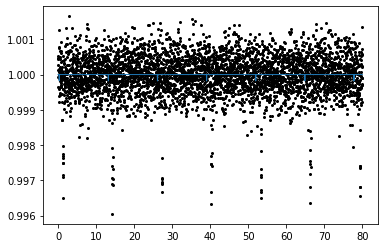

In [36]:
import matplotlib.pyplot as plt
plt.plot(t, flux, ".k", ms=4, label="data")
plt.plot(t, map_soln["y"], lw=1)

In [37]:
np.random.seed(8462852)
with model:
    trace = pm.sample(
        tune=5000,
        draws=10000,
        step=pm.Metropolis(),
        start=map_soln,
        cores=4,
        chains=4,
        return_inferencedata=True
    )

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [yerr]
INFO:pymc3:>Metropolis: [yerr]
>Metropolis: [b]
INFO:pymc3:>Metropolis: [b]
>Metropolis: [r]
INFO:pymc3:>Metropolis: [r]
>Metropolis: [us]
INFO:pymc3:>Metropolis: [us]
>Metropolis: [t0]
INFO:pymc3:>Metropolis: [t0]
>Metropolis: [logP]
INFO:pymc3:>Metropolis: [logP]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 100 seconds.
INFO:pymc3:Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 100 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [38]:
var_names = ["period", "t0", "r", "b", "us", "yerr"]
with model:
    summary = az.summary(trace, var_names=var_names)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
period,13.000,0.001,12.999,13.001,0.000,0.000,2220.0,3804.0,1.0
t0,1.300,0.003,1.295,1.305,0.000,0.000,2333.0,3716.0,1.0
r,0.049,0.001,0.048,0.051,0.000,0.000,1715.0,1673.0,1.0
b,0.142,0.090,0.000,0.295,0.002,0.002,1704.0,1228.0,1.0
us[0],0.464,0.243,0.011,0.863,0.006,0.005,1364.0,2024.0,1.0
us[1],0.269,0.345,-0.402,0.817,0.010,0.007,1157.0,1685.0,1.0
yerr,0.001,0.000,0.000,0.001,0.000,0.000,7546.0,7575.0,1.0


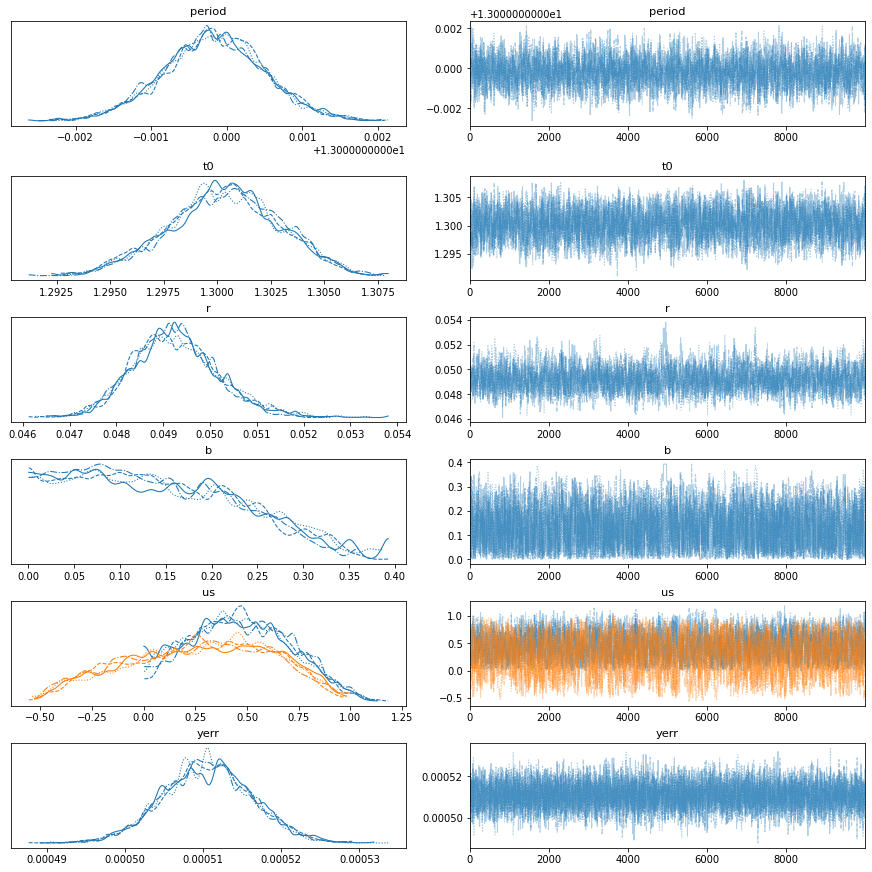

In [39]:
with model:
    az.plot_trace(trace, var_names=var_names);

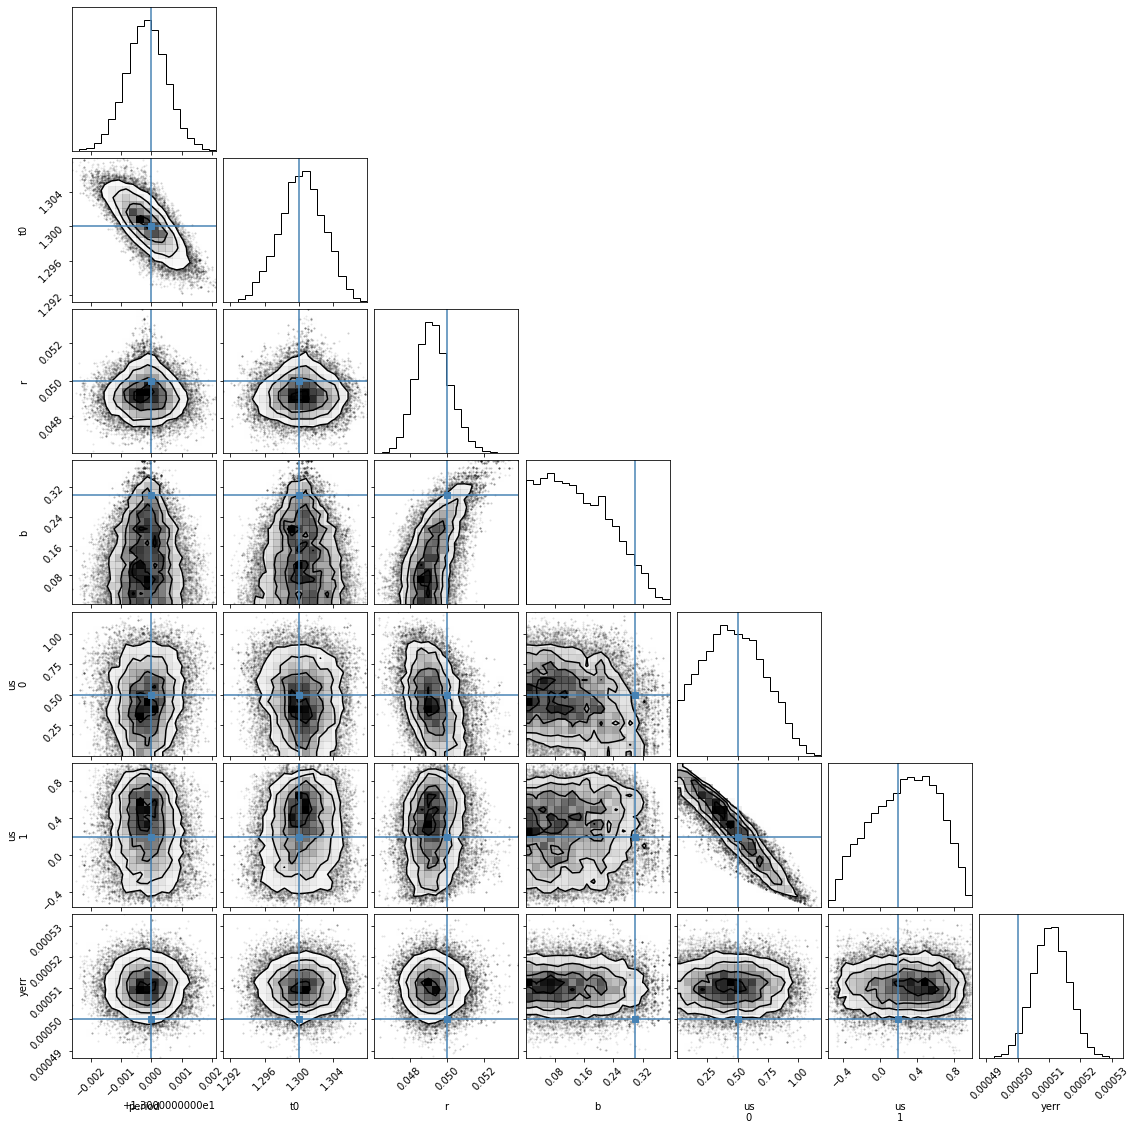

In [40]:
truth = [13, 1.3, 0.05, 0.3, 0.5, 0.2, 5e-4]
_ = corner.corner(
    trace,
    var_names=var_names,
    truths=truth,
)

In [41]:
model.test_point

{'logP': array(2.56494936),
 't0': array(0.),
 'us_quadlimbdark__': array([4.4408921e-16, 0.0000000e+00]),
 'r_interval__': array(0.),
 'b_impact__': array(-0.10436002),
 'yerr_log__': array(-2.30258509)}

In [43]:
true_point = {
    "logP": np.log(13),
    "t0": 1.3,
    "r_interval__": 0.05,
    "b_impact__": 0.3,
    "us_quadlimbdark__": [0.5, 0.2],
    "yerr_log__": np.log(5e-4)
}

with model:
    true_mod = xo.eval_in_model([y], true_point)[0]

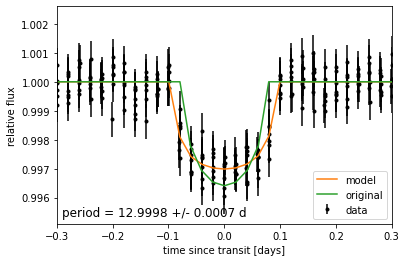

In [44]:
# Get the posterior median orbital parameters
p = np.median(trace["posterior"]["period"])
t0 = np.median(trace["posterior"]["t0"])

# Plot the folded data
x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
plt.errorbar(
    x_fold, flux, yerr=fluxerr, fmt=".k", label="data", zorder=-1000
)

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = trace["posterior"]["y"]
pred = np.median(pred, axis=(0, 1))
plt.plot(x_fold[inds], pred[inds], color="C1", label="model")
plt.plot(x_fold[inds], true_mod[inds], color="C2", label="original")

# Annotate the plot with the planet's period
Pmean = np.mean(trace["posterior"]["period"]).values
Pstd = np.std(trace["posterior"]["period"]).values
txt = f"period = {Pmean:.4f} +/- {Pstd:.4f} d"
plt.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5 * p, 0.5 * p)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux")
plt.xlim(-0.3, 0.3);

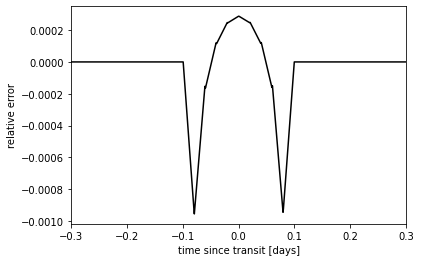

In [45]:
# Plot the folded model residuals
plt.plot(x_fold[inds], (pred[inds] + 1) / (true_mod[inds] + 1) - 1, color="k")
plt.xlim(-0.5 * p, 0.5 * p)
plt.xlabel("time since transit [days]")
plt.ylabel("relative error")
plt.xlim(-0.3, 0.3);